<a href="https://colab.research.google.com/github/cfong32/data6100-proj2/blob/master/data6100_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload "spaceship-titanic.zip"
# To be removed for project submission
from google.colab import files
from zipfile import ZipFile

uploaded = files.upload()
with ZipFile('spaceship-titanic.zip') as zip:
    zip.extractall()

Saving spaceship-titanic.zip to spaceship-titanic.zip


# I. Executive Summary

# II. Ethics Discussion

# III. Exploratory Data Analysis

In [3]:
###
# Import packages
###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.min_rows', 4)

In [4]:
###
# Read the whole dataset (train + test)
###

df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
df0 = pd.concat([df_train.assign(dataset='train'),  ## here train and test are merged
                 df_test.assign(dataset='test')])   ## so that they can be preprocessed together
df = df0.copy()                                     ## keep df0 untouch from EDA
display(df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,dataset
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,test
4276,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,test


## Numerical Features

We have a few observations:
- 'Age' is normal
- The distributions of 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' are very skewed.
    - There are so many number of zeros in these columns.

Basic statistics:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



Histograms:


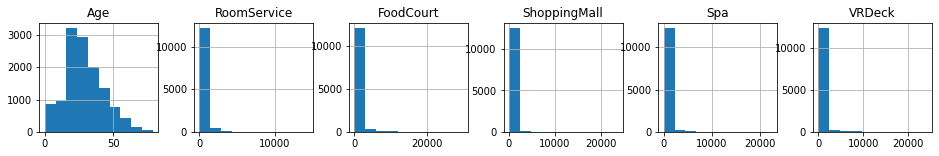


Cumulative step histograms:


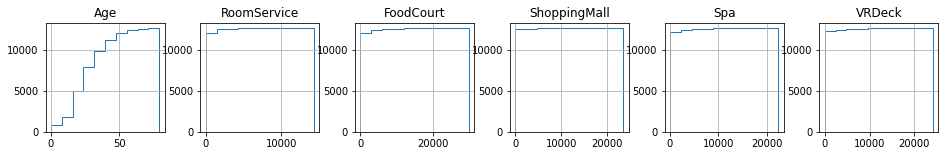


Number of zeros found in each column:


Age             0.020046
RoomService     0.640170
FoodCourt       0.628065
ShoppingMall    0.642328
Spa             0.611796
VRDeck          0.636237
dtype: float64

In [ ]:
###
# Look for characteristics of the numercial features
###

cols_num = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

## Show basic stats
print('Basic statistics:')
display(df[cols_num].describe())

## Plot normal histograms
print()
print('Histograms:')
fig, axes = plt.subplots(1,6, figsize=(16,2))
for i, col in enumerate(cols_num):
    df[[col]].hist(
        ax=axes.flat[i],
    )
plt.show()

## Cumulative step histograms
print()
print('Cumulative step histograms:')
fig, axes = plt.subplots(1,6, figsize=(16,2))
for i, col in enumerate(cols_num):
    df[[col]].hist(
        cumulative=True,
        histtype='step',
        ax=axes.flat[i],
    )
plt.show()

## Count how many of zeros are there
print()
print('Number of zeros found in each column:')
(df[cols_num] == 0).sum() / len(df)

## Categorical Features

# IV. Data Preprocessing

In [5]:
# read and print the original dataframe
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
df = pd.concat([df_train.assign(dataset='train'),   ## here train and test are merged
                df_test.assign(dataset='test')])    ## so that they can be preprocessed together
display(df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,dataset
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,test
4276,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,test


In [ ]:
# preprocessing
cols_to_fillna_with_median = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cols_to_get_zero = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']    ## changed
cols_to_get_dummies = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']
# cols_to_drop = ['PassengerId', 'Name', 'Cabin']       ## now we keep all columns
cols_to_float = ['Transported']

## make new categorical features, "is it zero or not?"
for col in cols_to_get_zero:
    df[f'zero{col}'] = (df[col] == 0).astype(float)

# make columns for "Cabin_deck" and "Cabin_side"
df['Cabin_deck'] = df.Cabin.str.split('/').map(lambda x: x[0] if isinstance(x, list) else np.NaN)
df['Cabin_side'] = df.Cabin.str.split('/').map(lambda x: x[2] if isinstance(x, list) else np.NaN)

# fillna with median values
for col in cols_to_fillna_with_median:
    df[col].fillna(df[col].median(), inplace=True)

# convert categorical columns into dummy variables
df = pd.concat([df.drop(columns=cols_to_get_dummies),
                pd.get_dummies(df[cols_to_get_dummies])],
               axis=1)

# convert some columns into float                       ## we need to use float
df[cols_to_float] = df[cols_to_float].astype(float)     ## because it allows test set to have NA

## # drop some columns                                  ## now we keep all columns
## df = df.drop(columns=cols_to_drop)

# print the preprocessed dataframe
df

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,...,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S
0,0001_01,B/0/P,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,...,0,1,0,0,0,0,0,0,1,0
1,0002_01,F/0/S,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,9273_01,D/297/P,27.0,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,...,0,0,0,1,0,0,0,0,1,0
4276,9277_01,G/1498/S,43.0,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
# input features, X
cols_X = [
    ## Let's consider ONLY the categorical features first
    ## Set 3 (31)
    # 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
    
    ## Set 2 (25)
    ## some numerical features has changed to categorical now
    'catRoomService_zero',
    'catFoodCourt_zero',
    'catShoppingMall_zero',
    'catSpa_zero',
    'catVRDeck_zero',

    ## Set 1 (20)
    'Cabin_deck_A', 'Cabin_deck_B', 'Cabin_deck_C', 'Cabin_deck_D',
    'Cabin_deck_E', 'Cabin_deck_F', 'Cabin_deck_G', 'Cabin_deck_T',
    'Cabin_side_P', 'Cabin_side_S',
    'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
    'CryoSleep_False', 'CryoSleep_True',
    'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
    'VIP_False', 'VIP_True',
]
# output target, y
col_y = 'Transported'

# make sure there is no NA
train_set = df.dataset=='train'                                 ## select only the training set
assert df[cols_X].notna().all().all()
assert df[train_set][col_y].notna().all().all()                 ## train_set

# standardize X and y
sr_mean_X, sr_std_X = df[cols_X].mean(), df[cols_X].std()
X_train = ((df[train_set][cols_X] - sr_mean_X) / sr_std_X).values    ## train_set
y_train = df[train_set][col_y].values                                ## train_set

X_train.shape, y_train.shape                                    ## renamed

((8693, 25), (8693,))

# V. Logistic Regression

In [ ]:
# try simple Logistic Regression

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=5)

print('5-fold cross-validation accuracies:')
scores

5-fold cross-validation accuracies:


array([0.72340426, 0.74410581, 0.75043128, 0.73878021, 0.73705409])

# VI. Discriminant Analysis

# VII. Interpretations and Comparsions

# VIII. Output for Kaggle Submission

In [ ]:
## the following are new

In [ ]:
## select only the test set

test_set = df.dataset=='test'                                       
X_test = ((df[test_set][cols_X] - sr_mean_X) / sr_std_X).values

X_test.shape

(4277, 25)

In [ ]:
## train a new model with all training data
## predict on test data

model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

y_hat.shape

(4277,)

In [ ]:
## create a table for submission

df_submission = pd.DataFrame({
    'PassengerId': df[test_set].PassengerId,
    'Transported': y_hat.astype(bool)
})

df_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
...,...,...
4275,9273_01,True
4276,9277_01,True


In [ ]:
###
# Save submission csv file
###

import pytz
from datetime import datetime, timezone

timestr = datetime.now(pytz.timezone('Canada/Eastern')).strftime("%y%m%d%H%M")

save_path = f'submission.{timestr}.csv'
df_submission.to_csv(save_path, index=False)
print('saved to', save_path)

saved to submission.2211081815.csv
